# Testing of Generalized Elliptical Slice Samplers

In [1]:
from generalized_elliptical_slice_sampling import generalized_ess, two_group_gess
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

In [2]:
d = 50
n_chains = 100
n_its = int(2e4)
x_0s = rnd.normal(scale=1, size=(2*n_chains,d))

In [3]:
true_df = 3
def log_density(x):
    return -(d + true_df)/2 * np.log(1 + np.sum(x**2)/true_df)

### Single-Chain, Fixed Approximation GESS

In [4]:
# choose the approximation's parameters slightly sub-optimal just to test the sampler's functionality
df_arg = 1
mean_arg = rnd.normal(scale=0.01, size=d)
tmp = rnd.normal(scale=0.1, size=(d,d))
scale_arg = np.identity(d) + tmp @ tmp.T

In [5]:
samples, gen, tde_cnts = generalized_ess(
    log_density,
    df_arg,
    mean_arg,
    scale_arg,
    n_its,
    x_0s[0],
    rnd,
    True,
)

100%|██████████████████████████████████| 20000/20000 [00:01<00:00, 17415.83it/s]


In [6]:
radii = mcu.get_radii(samples)

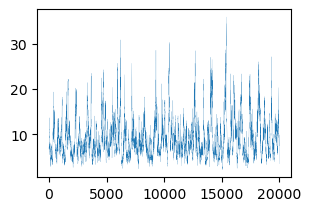

In [7]:
pfs.trace_plot(radii, lw=0.1)

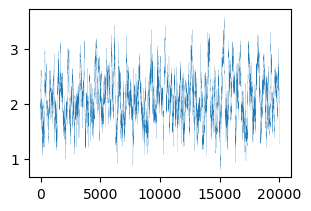

In [8]:
pfs.trace_plot(np.log(radii), lw=0.1)

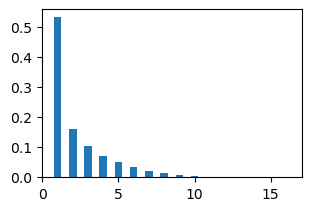

In [9]:
pfs.plot_tde_distr(tde_cnts[1:])

### Two-Group-Parallelized GESS

In [10]:
ret_dic = two_group_gess(
    log_density,
    n_chains,
    n_its,
    x_0s,
    # n_ibu=100,
)
samples = ret_dic['samples']
tde = ret_dic['tde_cnts']
dfs_G1, dfs_G2 = ret_dic['dfs']
centers_G1, centers_G2 = ret_dic['centers']
scale_G1, scale_G2 = ret_dic['scales']
schedule = ret_dic['schedule']

Checking validity of given arguments...
Preparing for parallel sampling...
Starting two-group sampling...


  0%|          | 0/20002 [00:00<?, ?it/s]

Assembling output...


In [11]:
radii = mcu.get_radii(samples)

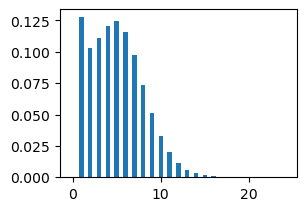

In [12]:
pfs.plot_tde_distr(tde)

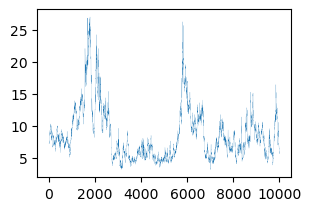

In [13]:
pfs.trace_plot(radii[:,0])

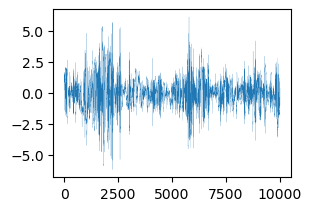

In [14]:
pfs.trace_plot(samples[:,0,0])

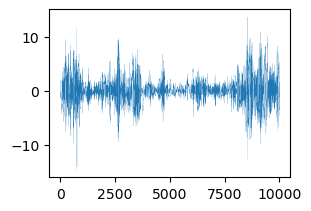

In [15]:
pfs.trace_plot(samples[:,n_chains,0])

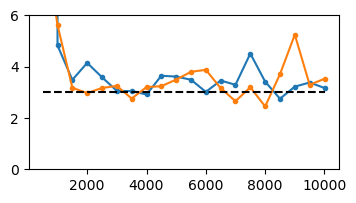

In [16]:
plt.figure(figsize=(4,2))
for dfs in [dfs_G1, dfs_G2]:
    plt.plot(schedule[1:], dfs[1:], marker='.')
plt.plot(schedule[1:], true_df * np.ones(len(dfs_G1)-1), linestyle="dashed", color="k")
plt.ylim((0,2*true_df))
plt.show()

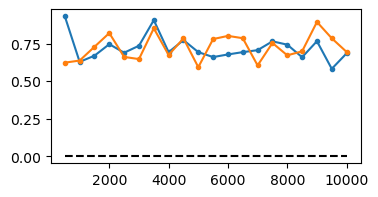

In [17]:
plt.figure(figsize=(4,2))
for cen in [centers_G1, centers_G2]:
    cen_radii = mcu.get_radii(cen)
    plt.plot(schedule[1:], cen_radii[1:], marker='.')
plt.plot(schedule[1:], np.zeros(len(cen)-1), linestyle="dashed", color="k")
plt.show()

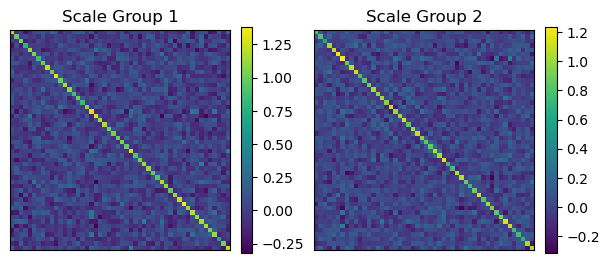

In [18]:
scales = [scale_G1, scale_G2]
titles = ["Scale Group 1", "Scale Group 2"]
pfs.plot_covs_row(scales, titles, dpi=100, shrink=0.775)

In [19]:
for scale in scales:
    print("{:.2f}".format(np.linalg.norm(scale - np.identity(d))))

5.63
4.94
